In [718]:
import numpy as np
from scipy.signal import correlate, welch, freqz
from scipy.io import wavfile as wav
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.fft import fft
from arch.unitroot import ADF, PhillipsPerron, KPSS
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy.io.wavfile
from IPython.display import Audio
from pydub import AudioSegment
import scipy.signal as sps
from statsmodels.tsa.filters.filtertools import recursive_filter

In [719]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("PhillipsPerron Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = KPSS(signal, lags=-1)
  kpss_p_value = kpss_result.pvalue
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [720]:
# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./a.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000

# Realiza el downsampling
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)

# Guarda el audio downsampled en un nuevo archivo
audio_downsampled.export("./a_16khz.wav", format="wav")

# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./sh.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)
audio_downsampled.export("./sh_16khz.wav", format="wav")


<_io.BufferedRandom name='./sh_16khz.wav'>

Se evalua si el sistema es estacionario. Se trató de que la grabación sea lo más estable posible, pero se trató de asegurarse que lo fuera. 

In [721]:
#Valor significativo: 
alpha = 0.05
#95% de confianza
a_sr, signal_a = wav.read("./a_16khz.wav")
signal_a_aux = signal_a.ravel()
sh_sr, signal_sh = wav.read("./sh_16khz.wav")
signal_sh_aux = signal_sh.ravel()


# Convertir a mono
a_mono = np.mean(signal_a, axis=1)
sh_mono =  np.mean(signal_sh, axis=1)

a_mono = a_mono - np.mean(a_mono)
a_mono = a_mono / np.abs(np.argmax(a_mono))
a_mono = a_mono[1*16000:2*16000]
sh_mono = sh_mono - np.mean(sh_mono)
sh_mono = sh_mono / np.abs(np.argmax(sh_mono))
sh_mono = sh_mono[1*16000:2*16000]



In [722]:
EsEstacionario(signal_a_aux/np.max(abs(signal_a)), alpha)

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:249: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan


PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


In [723]:
EsEstacionario(signal_sh_aux/np.max(abs(signal_sh)), alpha)

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]


PhillipsPerron Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Not stationary


c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


ploteo las señales

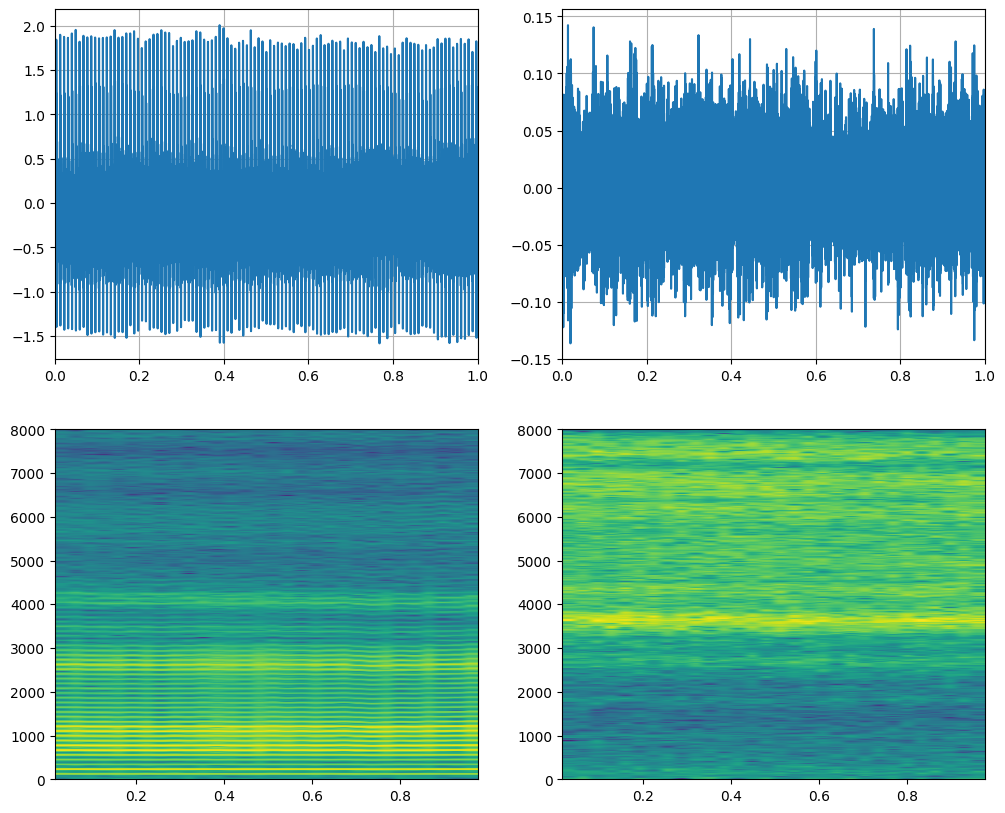

In [724]:
# Crear subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotear las señales
axs[0, 0].grid()
axs[0, 0].set_xlim(0, len(a_mono) / a_sr)
axs[0, 0].plot(np.arange(len(a_mono)) / a_sr, a_mono)
axs[1, 0].specgram(a_mono, Fs=a_sr, cmap='viridis', NFFT=1024, noverlap=512)

axs[0, 1].grid()
axs[0, 1].set_xlim(0, len(sh_mono) / sh_sr)
axs[0, 1].plot(np.arange(len(sh_mono)) / sh_sr, sh_mono)
axs[1, 1].specgram(sh_mono, Fs=sh_sr, cmap='viridis', NFFT=1024, noverlap=512)

plt.show()

In [725]:
signal_a = a_mono
signal_sh = sh_mono

A se evalua el error forward para diferentes órdenes de filtro. Es notorio que el caso del fonema /sh/ el gráfico contiene solo un codo (aprox. en M=15), mientras que para el fonema /a/ resulta haber dos (aprox. en M=15 y M=160).

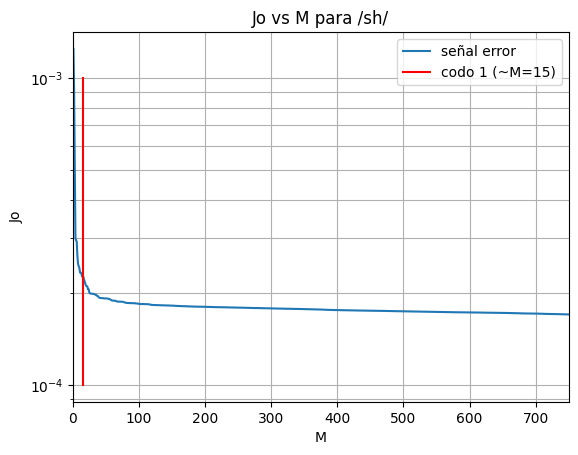

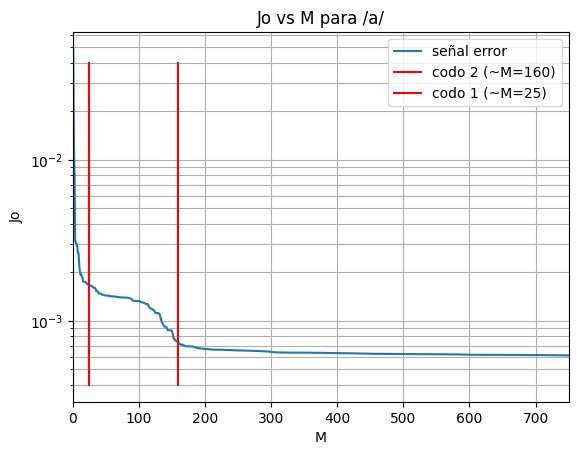

In [726]:
m_array = [i for i in range(1,1500)]
#m_array = [int(x) for x in (np.logspace(0, 4.2, num = 1000))]
N = len(signal_sh)
r = correlate(signal_sh, signal_sh, 'full')[len(signal_sh)-1:] / len(signal_sh)
Jo_sh_array = []
a0_sh_array = []
for m in m_array:
    r_forward = np.conjugate(r[1:m+1]) 
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_sh_array.append(jo)
    a0_sh_array.append(a0)

plt.title('Jo vs M para /sh/')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,750)
plt.grid(which='both')
plt.semilogy(m_array, Jo_sh_array,label = 'señal error')
plt.plot([15, 15], [1e-4,0.1e-2], 'r-', label = 'codo 1 (~M=15)')
plt.legend()
plt.show()

m_array = [i for i in range(1,2000)]
#m_array = [int(x) for x in (np.logspace(0, 4.2, num = 1000))]
N = len(signal_a)
r = correlate(signal_a, signal_a, 'full')[len(signal_a)-1:] / len(signal_a)
Jo_a_array = []
a0_a_array = []
for m in m_array:
    r_forward = np.conj(r[1:m+1]) 
    a0 = linalg.solve_toeplitz(r[:m], -1*r_forward)
    jo = r[0] + np.dot(r[1:m+1], np.transpose(a0))
    Jo_a_array.append(jo)
    a0_a_array.append(a0)

plt.title('Jo vs M para /a/')
plt.xlabel('M')
plt.ylabel('Jo')
plt.xlim(0,750)
plt.grid(which='both')
plt.semilogy(m_array, Jo_a_array,label = 'señal error')
plt.plot([160, 160], [4e-4,4e-2], 'r-', label = 'codo 2 (~M=160)')
plt.plot([25, 25], [4e-4,4e-2], 'r-', label = 'codo 1 (~M=25)')
plt.legend()
plt.show()

Investigando la señal correspondiente a /a/ notamos ciertas cuestiones. Primero, observando los espectrogramas se puede notar que la señal /a/ contiene componentes periódicas. Esto es una diferencia respecto de la señal /sh/. Es evidente que cuando se entona el fonema /a/, debe haber un armónico principal seguido de una serie de armónicos sumado a acoplado a cierto nivel de ruido y que el fonema /sh/ tiene un comportamiento únicamente ruidoso. Esto se evidencia en los espectrogramas realizados. 

A continuación se muestran los periodogramas de las dos señales. Y son notorias tres cosas: 

1. El armónico principal de /a/ se encuentra aproximadamente en 150hz.  
2. El segundo codo (M~160) se corresponde con el armónico principal.
3. El codo 2 (M~15) se corresponde con el punto a partir del cual aparece un nivel de energía no asociado al los armónicos.

<Figure size 600x200 with 0 Axes>

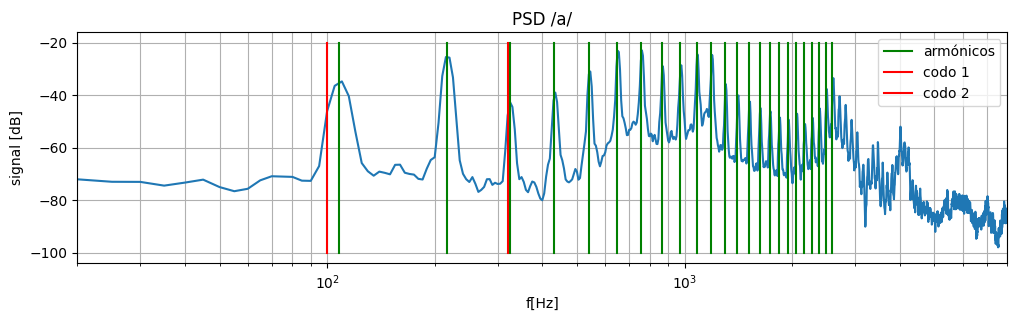

In [727]:
plt.figure(figsize=(6,2))
segnum = 5
f, Pxx_den = welch(signal_a, fs=16000, window='parzen', nperseg=len(signal_a)//segnum, noverlap=len(signal_a)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Pxx_den))
plt.title('PSD /a/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
codo1 = [16000/25, 16000/25]
armonicos = np.array([16000/148, 16000/148])

for i in range(1,25):
    if i==1:    
        plt.plot(i*armonicos, [-100, -20], 'g', label='armónicos')
    else:
        plt.plot(i*armonicos, [-100, -20], 'g')

plt.plot([16000/50, 16000/50], [-100, -20], 'r', label = 'codo 1')
plt.plot([16000/160, 16000/160], [-100, -20], 'r', label = 'codo 2')

plt.legend()
plt.show()

<Figure size 600x200 with 0 Axes>

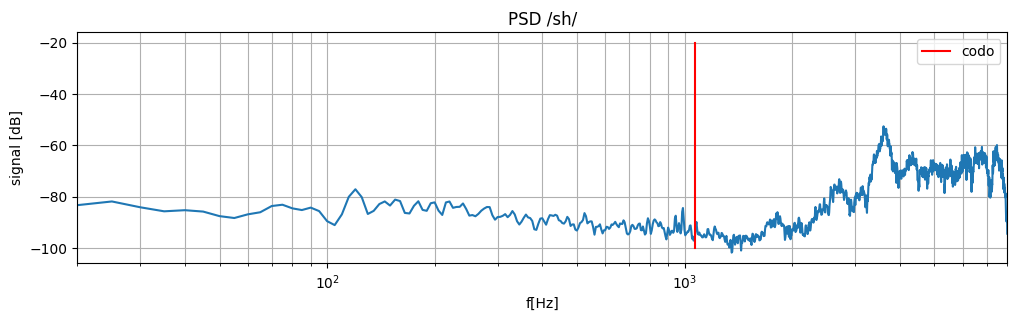

In [728]:
plt.figure(figsize=(6,2))
segnum = 5
f, Pxx_den = welch(signal_sh, fs=16000, window='parzen', nperseg=len(signal_a)//segnum, noverlap=len(signal_a)//segnum//2, detrend='constant', return_onesided=True, scaling='density')

plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Pxx_den))
plt.title('PSD /sh/')
plt.xlabel('f[Hz]')
plt.ylabel('signal [dB]')
plt.xlim(20,8000)
plt.grid(which='both')
codo1 = [16000/15, 16000/15]

plt.plot(codo1, [-100, -20], 'r', label = 'codo')


plt.legend()
plt.show()

Es decir, a medida que M crece el filtro puede incorporar información de frecuencias cada vez más bajas de la señal, que deja de estar en el error forward. Cuando M es 1, la PSD del error fowrward, lógicamente, es prácticamente igual a la señal de entrada. Sin embargo a medida que aumenta, las componentes de mayor frecuencia comienzan a desaparecer de la misma. Luego del primer codo, la energía observada anteriormente en frecuencias medias disminuye y pasando el segundo codo también desaparecen los armónicos principales. 

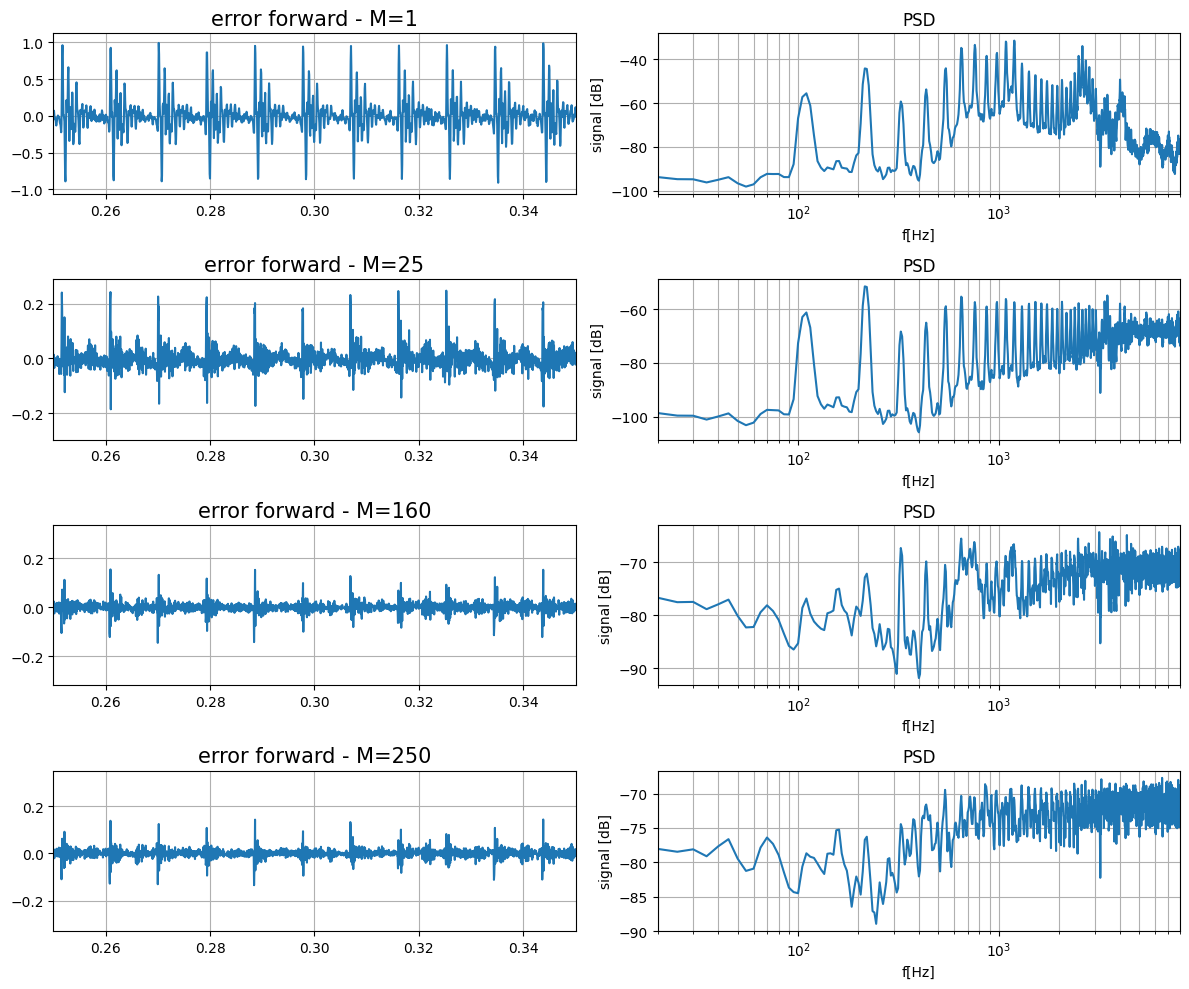

In [729]:
def analyze_e_f(i, ax, M = 250):
    a_error = np.concatenate(([1], a0_a_array[M-1]))
    error_forward = np.convolve(signal_a, a_error, mode='full')[:len(signal_a)]

    ax[i, 0].set_title('error forward - M=' + str(M), fontsize=15)
    ax[i, 0].plot(np.arange(len(error_forward))/16000,error_forward)
    ax[i, 0].set_xlim(0.25,0.35)
    ax[i, 0].grid(which='both')

    segnum = 5
    f, Pxx_den = welch(error_forward, fs=16000, window='parzen', nperseg=len(error_forward)//segnum, noverlap=len(error_forward)//segnum//2, detrend='constant', return_onesided=True, scaling='density')


    ax[i, 1].semilogx(f, 10*np.log10(Pxx_den))
    ax[i, 1].set_title('PSD')
    ax[i, 1].set_xlabel('f[Hz]')
    ax[i, 1].set_ylabel('signal [dB]')
    ax[i, 1].set_xlim(20,8000)
    ax[i, 1].grid(which='both')
    return i+1

m_arr = [1,25, 160, 250]
i = 0
fig, ax = plt.subplots(len(m_arr), 2, figsize=(12, 10))  # Create a 2x2 grid of subplots and select the first one
for m in m_arr:
    i = analyze_e_f(i, ax, m)
fig.tight_layout()
plt.show()

Para las grabaciones del punto 1, representen la respuesta en frecuencia H(ejω)
del filtro del error de predicción ā (no el filtro predictor a) para M = 1, 2, 4, 8, 16,
32, 64. Expliquen y justifiquen los resultados obtenidos, teniendo en cuenta J(M)
y ef
(n).

In [730]:
m_array = [1, 2, 4, 8, 16, 32, 64]

a_arr_a = [np.concatenate(([1],a0_a_array[1-1])),
         np.concatenate(([1],a0_a_array[2-1])),
         np.concatenate(([1],a0_a_array[4-1])),
         np.concatenate(([1],a0_a_array[8-1])),
         np.concatenate(([1],a0_a_array[16-1])),
         np.concatenate(([1],a0_a_array[32-1])),
         np.concatenate(([1],a0_a_array[64-1]))]

a_arr_sh = [np.concatenate(([1],a0_sh_array[1-1])),
            np.concatenate(([1],a0_sh_array[2-1])),
            np.concatenate(([1],a0_sh_array[4-1])),
            np.concatenate(([1],a0_sh_array[8-1])),
            np.concatenate(([1],a0_sh_array[16-1])),
            np.concatenate(([1],a0_sh_array[32-1])),
            np.concatenate(([1],a0_sh_array[64-1]))]




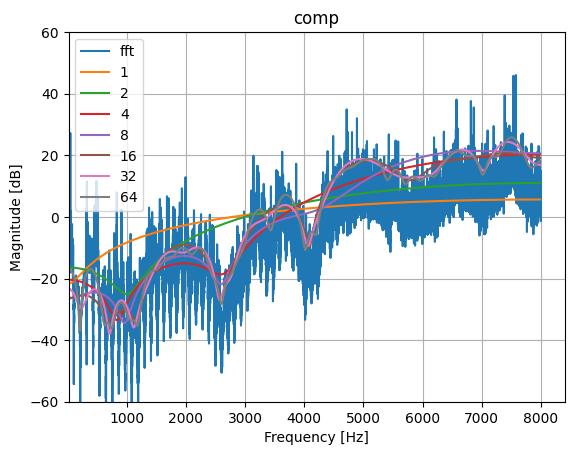

In [731]:
fft_result = np.fft.fft(signal_a)

frequencies = np.fft.fftfreq(len(fft_result), 1/16000)
frequencies = frequencies[:len(frequencies)//2-1]
fft_result = fft_result[:len(fft_result)//2-1:]
plt.plot(frequencies, 20 * np.log10(np.abs(1/fft_result)), label= 'fft')
plt.xlim(20,)
plt.ylim(-60,60)

for i, a in enumerate(a_arr_a):
    w, h = freqz(a, fs = 16000)
    plt.plot(w, 20 * np.log10(np.abs(h)), label= str(m_array[i]))


plt.title('comp')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.show()

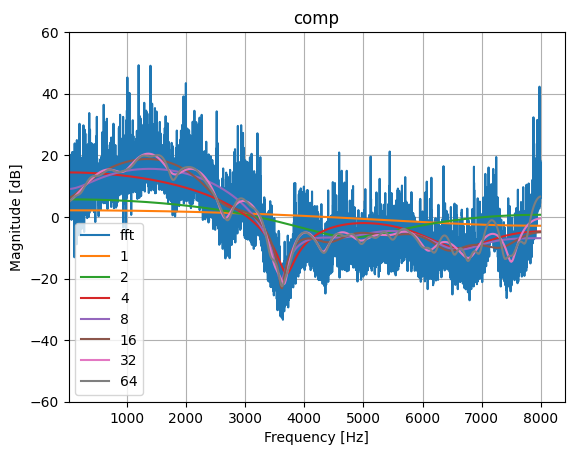

In [732]:

fft_result = np.fft.fft(signal_sh)

frequencies = np.fft.fftfreq(len(fft_result), 1/16000)
frequencies = frequencies[:len(frequencies)//2-1]
fft_result = fft_result[:len(fft_result)//2-1:]
plt.plot(frequencies, 20 * np.log10(np.abs(1/fft_result)), label= 'fft')
plt.xlim(20,)
plt.ylim(-60,60)

for i, a in enumerate(a_arr_sh):
    w, h = freqz(a, fs = 16000)
    plt.plot(w, 20 * np.log10(np.abs(h)), label= str(m_array[i]))


plt.title('comp')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.show()

# punto 4

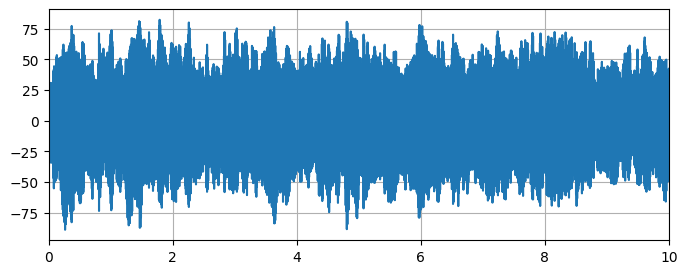

In [733]:
M = 12
a_aux = a0_a_array[M]
a_error = np.concatenate(([1], a_aux))
error_forward = np.convolve(signal_a, a_error, mode='full')[:len(signal_a)] #[len(signal_a):]
# Compute filter
a_a = a_aux
# Compute error signal
a_err = error_forward
# Compute autocorrelation for /a/ signal.
error_forward_corr = correlate(error_forward, error_forward, method='fft', mode='same')[len(error_forward)//2:] / (len(error_forward))
# Normalize autocorrelation
error_forward_corr = error_forward_corr / np.abs(np.max(error_forward_corr))
# AR model order
a_k = 350

# Calulate AR filter
# Compute the right-hand side vector from lagged autocorrelations
R = error_forward_corr[:a_k]
r = error_forward_corr[1:a_k+1]
# Solve the Yule-Walker equations to estimate AR coefficients
a_ar = linalg.solve_toeplitz(R, r)

a_reb_error = signal.lfilter([1], np.concatenate(([1], -a_ar)), np.random.normal(size=10*16000))

#Hacemos el filtrado inverso

a_reb_signal = sps.lfilter([1], np.concatenate(([1],a_a)), a_reb_error) # error_forward)

# Plotear las señales
plt.figure(figsize=(8, 3))
plt.grid(which='both')
plt.xlim(0, len(a_reb_signal) / a_sr)
plt.plot(np.arange(len(a_reb_signal)) / a_sr, a_reb_signal)
plt.show()

from IPython.display import Audio
from scipy.io import wavfile
wavfile.write('./RESINTETIZADO_AV2.wav', 16000, np.int16(a_reb_signal*32767/(2*np.max(a_reb_signal))))
Audio('./RESINTETIZADO_AV2.wav')

punto5

In [734]:
# Carga el archivo WAV original
original_audio = AudioSegment.from_file("./test.wav")

# Define la frecuencia de muestreo deseada (16 kHz en este caso)
nueva_frecuencia = 16000

# Realiza el downsampling
audio_downsampled = original_audio.set_frame_rate(nueva_frecuencia)

# Guarda el audio downsampled en un nuevo archivo
audio_downsampled.export("./test_16khz.wav", format="wav")

<_io.BufferedRandom name='./test_16khz.wav'>

In [735]:
ds_sr, discurso = wav.read("./test_16khz.wav")
discurso = discurso - np.mean(discurso)
discurso = discurso / np.abs(np.argmax(discurso))
discurso = np.mean(discurso, axis=1)

In [738]:
# Definir la longitud de la ventana y el overlap
ventana_longitud = int(ds_sr * 0.05)  # 50 ms en muestras (fs es la frecuencia de muestreo)

overlap = ventana_longitud // 2  # 50% de superposición
senal_final = np.zeros(len(discurso))
# Definir el orden de predicción M
M = 25
# Frecuencia del tren de impulsos
fs_impulsos = 160  # Hz
impulsos = [1 if (j%100==0) else 0 for j in range(len(discurso))]
# Crear una ventana de Hann
ventana = np.hanning(ventana_longitud)
# Iterar sobre los bloques de señal con superposición
for i in range(0, len(discurso) - ventana_longitud, ventana_longitud - overlap):

    bloque_signal = discurso[i:i + ventana_longitud] 
    bloque_signal *= ventana
    r = correlate(bloque_signal, bloque_signal, 'full')[len(bloque_signal)-1:] / len(bloque_signal)
    r_forward = np.conj(r[1:M]) 
    a0 = linalg.solve_toeplitz(r[:M-1], -1*r_forward)
    a_error = np.concatenate(([1], a0[:M])) 

    bloque_error = sps.lfilter([1], a_error, impulsos[i:i+ventana_longitud]) # * ventana

    senal_final[i:i + ventana_longitud] += bloque_error

wavfile.write('./discurso_sintetizado.wav', 16000, np.int16(senal_final*32767/(np.max(senal_final))))
Audio('./discurso_sintetizado.wav')

In [737]:
Audio('./discurso_16khz.wav')